In [37]:
# pip install --user sklearn
import sys
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
#! pip install --user pandas
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score

## 1. Levantamos el dataset

In [38]:

fake = pd.read_csv("../archive/Fake.csv")
true = pd.read_csv("../archive/True.csv")

# ponemos los dos en uno
fake["label"] = 1
true["label"] = 0
df = pd.concat([fake, true], ignore_index = True)
print(df.title)

0         Donald Trump Sends Out Embarrassing New Year’...
1         Drunk Bragging Trump Staffer Started Russian ...
2         Sheriff David Clarke Becomes An Internet Joke...
3         Trump Is So Obsessed He Even Has Obama’s Name...
4         Pope Francis Just Called Out Donald Trump Dur...
                               ...                        
44893    'Fully committed' NATO backs new U.S. approach...
44894    LexisNexis withdrew two products from Chinese ...
44895    Minsk cultural hub becomes haven from authorities
44896    Vatican upbeat on possibility of Pope Francis ...
44897    Indonesia to buy $1.14 billion worth of Russia...
Name: title, Length: 44898, dtype: object


## 2. Preprocesamiento: limpiamos el texto

In [39]:

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    # agregar otras...
    return text

df.title = df.title.map(clean_text)
df.text = df.text.map(clean_text)

## 3. Vectorizamos el texto

Hicimos la experimentación utilizando dos vectorizadores de texto distintos:
- Count Vectorizer, que simplemente cuenta la cantidad de apariciones de cada palabra.
- Term Frequency Inverse Document Frequency, que incrementa proporcionalmente con la cantidad de apariciones de la palabra pero contrarresta con el número de documentos en el que está presente, permitiendo así que las palabras demasiado frecuentes y sin valor semántico no sean un problema.

In [58]:
USE_COUNT_VECTORIZER = False # Con este parametro controlamos cual vectorizador usar

In [59]:
##COUNT VECTORIZER
# removemos palabras con muy alta o muy baja frecuencia. ademas, removemos las "stop words" del inglés
# (palabras como 'the', 'a', 'he', 'her', etc.)
MAX_FREQ_THRESHOLD = 0.8
MIN_FREQ_THRESHOLD = 0.003
kwargs = {
    'stop_words': 'english',
    'max_df': MAX_FREQ_THRESHOLD,
    'min_df': MIN_FREQ_THRESHOLD
}
# DOCS: 
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vect = CountVectorizer(**kwargs) if USE_COUNT_VECTORIZER else TfidfVectorizer(**kwargs)
data_vectorized_titles = vect.fit_transform(df.title)
# print(cv.get_feature_names())  # vocabulario
# print(len(cv.get_feature_names())) # tamaño del vocabulario
data_dtm = pd.DataFrame(data_vectorized_titles.toarray(), columns=vect.get_feature_names())
data_dtm.index = df.index



## 4. Análisis exploratorio de datos

### 4.1 ¿Cuáles son las palabras más frecuentes en cada tipo de noticia?

#### Palabras más frecuentes en las noticias falsas

In [61]:
data_fake = data_dtm[:len(fake)]
data_fake = data_fake.transpose()
data_fake_top = data_fake.sum(axis=1).sort_values(ascending=False)[:60]
fake_dict = list(zip(data_fake_top.index, map(round, data_fake_top.values)))
fake_dict[:10]

[('trump', 1749),
 ('video', 1147),
 ('watch', 735),
 ('hillary', 688),
 ('obama', 657),
 ('just', 567),
 ('trumps', 554),
 ('president', 436),
 ('clinton', 406),
 ('donald', 404)]

#### Palabras más frecuentes en las noticias verdaderas

In [ ]:
data_true = data_dtm[len(fake):len(fake)+len(true)]
data_true = data_true.transpose()
data_true_top = data_true.sum(axis=1).sort_values(ascending=False)[:60]
true_dict = list(zip(data_true_top.index, map(round, data_true_top.values)))

"""
Esto es truchisimo pero estamos sacando la palabra que mas aparece que es 'says'
"""
true_dict.pop(1) 
true_dict[:10]

#### Y para visualizarlo un poco más lindo, usemos un WordCloud:

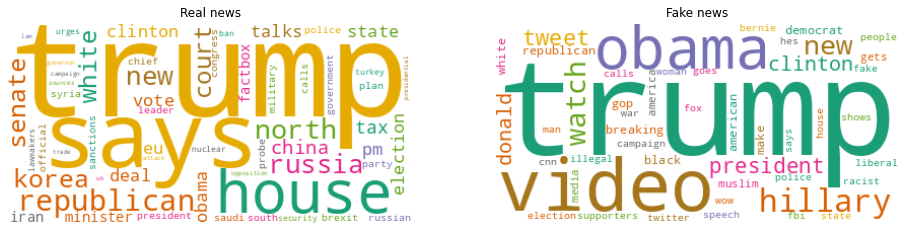

In [65]:
from wordcloud import WordCloud

wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42, collocations=False)

# Reset the output dimensions
import matplotlib.pyplot as plt

data_true_str = ''.join([(x[0] + ' ')*x[1] for x in true_dict])
data_fake_str = ''.join([(x[0] + ' ')*x[1] for x in fake_dict])
plt.rcParams['figure.figsize'] = [16, 6]
titles = ['Real news', 'Fake news']
data = [data_true_str, data_fake_str]
# Create subplots for each comedian
for index, data_str in enumerate(data):
    wc.generate(data[index])
    
    plt.subplot(1,2, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(titles[index])
    
plt.show()

- Las palabras que vemos tienen todas un buen valor semántico, indicando que el preprocesamiento del texto que hicimos es bueno. 
- Parecería que las noticias falsas tienen que ver con temas sociales
- Y que las noticias verdaderas hablan más de economía y política internacional.

### Y la parte más jugosa: técnicas de NLP para clasificar las noticias

In [68]:
Y = df['label'].to_numpy()
X = data_dtm.to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)

In [69]:
Y = df['label'].to_numpy()
X = data_dtm.to_numpy()

train_size = []
accuracy = []
for train_sz in np.arange(0.01, 0.99, 0.05):
    print(train_sz)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1-train_sz, random_state=42, shuffle=True)
    lr = LogisticRegression()
    lr.fit(X_train,Y_train)
    score_lr = lr.score(X_test, Y_test)
    train_size.append(train_sz)
    accuracy.append(score_lr)

0.01
0.060000000000000005
0.11
0.16000000000000003
0.21000000000000002
0.26
0.31000000000000005
0.36000000000000004
0.41000000000000003
0.46
0.51
0.56
0.6100000000000001
0.66
0.7100000000000001
0.76
0.81
0.8600000000000001
0.91
0.9600000000000001


In [70]:
accuracy

[0.7776827896512936,
 0.852671484421277,
 0.8621871871871872,
 0.8656502717751557,
 0.8692416126303919,
 0.8718133935289691,
 0.8728534538411878,
 0.8733600139203063,
 0.8748206870517177,
 0.8751907609816457,
 0.8763692559429117,
 0.8743672808260782,
 0.8749928616298327,
 0.8766540023581816,
 0.8761999846401967,
 0.8776911655530809,
 0.8756300550931896,
 0.8755965637925549,
 0.8767631774313289,
 0.8841870824053452]

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


Text(0, 0.5, 'Accuracy')

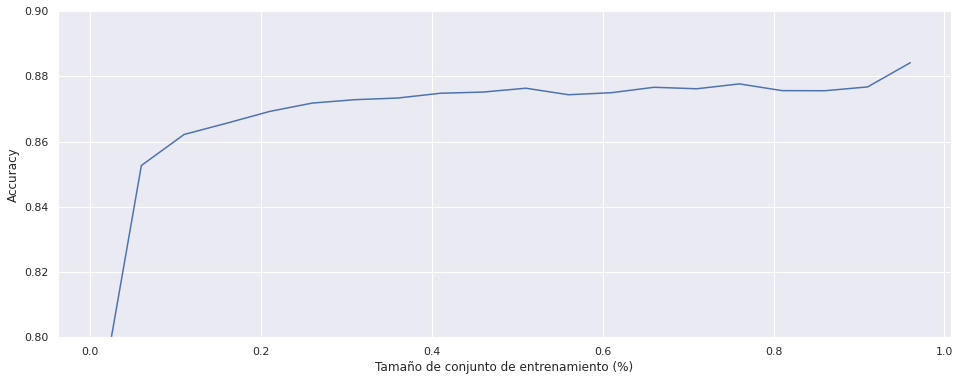

In [72]:
plt.plot(train_size, accuracy)
plt.ylim(0.8,0.9)
plt.xlabel("Tamaño de conjunto de entrenamiento (%)")
plt.ylabel("Accuracy")

In [73]:
print(f"Number of training examples: {X_train.shape[0]}")
print(f"Number of testing examples: {X_test.shape[0]}")

Number of training examples: 43102
Number of testing examples: 1796


In [74]:
Y_train


array([0, 1, 0, ..., 0, 1, 1])

In [75]:
lr = LogisticRegression()
clf = svm.SVC(kernel='rbf', max_iter=10000) 


In [76]:
#lr.fit(X_train,Y_train)
clf.fit(X_train, Y_train)

/home/matias/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(max_iter=10000)

In [77]:
#score_lr = lr.score(X_test, Y_test)
score_sv = clf.score(X_test, Y_test)
#print(f"Accuracy Lr: {score_lr}")
print(f"Accuracy SV: {score_sv}")

Accuracy SV: 0.8975501113585747


# De acá en adelante todo va con Cross validation

In [10]:
#Cross validation con LogisticRegression

Y = df['label'].to_numpy()
X = data_dtm.to_numpy()

y_graph = []
x_means = []
error =[]

for i in [3,5,10,20,50]:
    lr = LogisticRegression()
    scores = cross_val_score(lr, X, Y, cv=i)
    x_means.append(scores.mean())
    y_graph.append(i) #cantidad de splits
    error.append(scores.std())
    print("Con", i, "splits el promedio es de", scores.mean())



Con 3 splits el promedio es de 0.8386565103122634
Con 5 splits el promedio es de 0.8500382456367503
Con 10 splits el promedio es de 0.8596366371446958
Con 20 splits el promedio es de 0.8678760287269393
Con 50 splits el promedio es de 0.8732424091192368


In [ ]:
#SVM lineal
Y = df['label'].to_numpy()
X = data_dtm.to_numpy()
y_graph = []
x_means = []
error =[]

for i in [3,5,10,20]:
    clf = svm.SVC(kernel='linear', max_iter=5000) 
    scores = cross_val_score(clf, X, Y, cv=i)
    x_means.append(scores.mean())
    y_graph.append(i) #cantidad de splits
    error.append(scores.std())
    print("Con", i, "splits el promedio es de", scores.mean())

/home/santiago/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/santiago/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/santiago/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Con 3 splits el promedio es de 0.8380774199296183


/home/santiago/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/santiago/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/santiago/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/santiago/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/sa

Con 5 splits el promedio es de 0.8417976565462941


/home/santiago/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/santiago/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/santiago/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/santiago/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/sa

Con 10 splits el promedio es de 0.8381442784415853


/home/santiago/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/santiago/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [ ]:
#SVM poly
Y = df['label'].to_numpy()
X = data_dtm.to_numpy()
y_graph = []
x_means = []
error =[]

for i in [3,5,10,20]:
    clf = svm.SVC(kernel='poly', max_iter=5000) 
    scores = cross_val_score(clf, X, Y, cv=i)
    x_means.append(scores.mean())
    y_graph.append(i) #cantidad de splits
    error.append(scores.std())
    print("Con", i, "splits el promedio es de", scores.mean())

In [ ]:
#SVM RBF
Y = df['label'].to_numpy()
X = data_dtm.to_numpy()
y_graph = []
x_means = []
error =[]

for i in [3,5,10,20]:
    clf = svm.SVC(kernel='rbf', max_iter=5000) 
    scores = cross_val_score(clf, X, Y, cv=i)
    x_means.append(scores.mean())
    y_graph.append(i) #cantidad de splits
    error.append(scores.std())
    print("Con", i, "splits el promedio es de", scores.mean())

In [1]:
print(y_graph)
print(x_means)
print(error)

NameError: name 'y_graph' is not defined

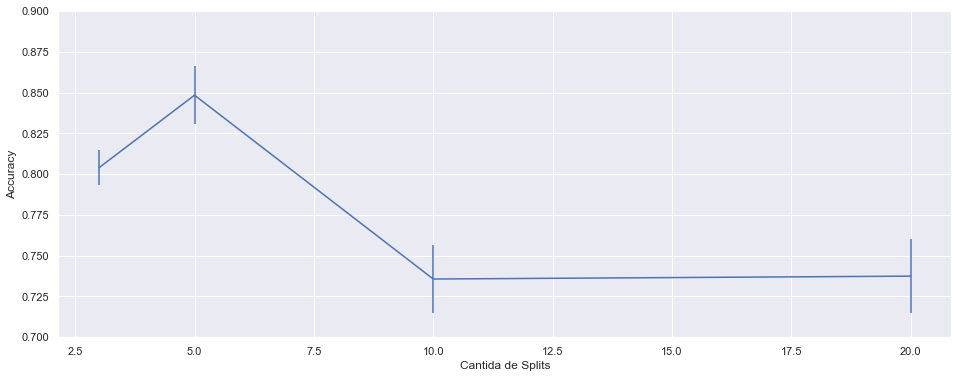

In [34]:
plt.errorbar(y_graph, x_means,error)
plt.xlabel("Cantida de Splits")
plt.ylabel("Accuracy")
plt.ylim(0.7,0.9)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5, verbose=2)
knn_gscv.fit(X_train, Y_train)

In [38]:
"""
TODO:

- Probar con otros valores (idealmente no arbitrarios) de MIN_FREQUENCY y MAX_FREQUENCY
- Hacer grafiquitos lindos
- Probar usando solo los títulos de la noticia, ignorar el texto. (DONE)
- Experimentar variando el max_iter tanto de SVM como de LogisticRegression
- Entender qué carajo son las iteraciones
- Experimentar cambiando la función kernel de SVM (poly, rbf, linear, sigmoid (Sigmoid Freud))
- Experimentar variando el tamano del conjunto de entrenamiento (train_set)
- Por defecto SVM tiene max_iter=-1 iteraciones y parece que no termina (converge?) nunca, pero por ahora no lo corrimos
más de 5 minutos, estaría bueno dejar corriéndolo un rato y ver si termina.

Resultados para recordar:
Hasta ahora SVM dio mejor con kernel=rbf (88,8% de accuracy con 10.000 iteraciones).
""" 

'\nTODO:\n\n- Probar con otros valores (idealmente no arbitrarios) de MIN_FREQUENCY y MAX_FREQUENCY\n- Hacer grafiquitos lindos\n- Probar usando solo los títulos de la noticia, ignorar el texto.\n'